In [28]:
# %pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import r2_score 
from scipy.optimize import differential_evolution, minimize
import glob
import os

In [29]:
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../dados/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    return data_frames
data_frames = import_dfs()
print(data_frames[0].columns)

../dados\5.100nh40ab80.csv
../dados\5.101nh5ab80.csv
../dados\5.102nh20ab40.csv
../dados\5.103nh40ab30.csv
../dados\5.106nh100ab40.csv
../dados\5.107nh55ab55.csv
../dados\5.109nh5ab55.csv
../dados\5.110nh10ab55.csv
../dados\5.112nh78ab35.csv
../dados\5.45nh60ab20.csv
../dados\5.46nh30ab30.csv
../dados\5.47nh5ab80.csv
../dados\5.48nh20ab80.csv
../dados\5.80nh12ab40.csv
../dados\5.81nh5ab30.csv
../dados\nh60ab80.csv
Index(['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm', 'apa_t'], dtype='object')


In [30]:
x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']


In [31]:
Cez = 1

kcat1        = 0.181
kcat2        = 0.395
Km1          = 5.449
Km2          = 1.694
Tmax         = 0.824
Ken          = 7.947
kAB          = 0.682
kAN          = 1.989
kAOH         = 9.856
kNH          = 9.763

P = np.zeros(10)
P[0]   = kcat1    
P[1]   = kcat2    
P[2]   = Km1      
P[3]   = Km2      
P[4]   = Tmax     
P[5]   = Ken      
P[6]   = kAB      
P[7]   = kAN      
P[8]   = kAOH     
P[9]  = kNH 

Np = len(P)

In [32]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)                                           

In [52]:
def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P)

In [51]:
def calculate_errorR2(model_output, experimental_data,params):
    total_error = np.sum((model_output - experimental_data) ** 2)
    return total_error

In [74]:
def calculate_errorL1(model_output, experimental_data,params):
    lmbd = 0.1
    total_error = np.sum((model_output - experimental_data) ** 2) + lmbd*np.sum(np.abs(params))
    return total_error


In [75]:
def calculate_errorL2(model_output, experimental_data,params):
    lmbd = 0.1
    total_error = np.sum((model_output - experimental_data) ** 2) + lmbd*np.sum(params)
    return total_error

In [58]:
def objective_function(params):
    record.append(params)
    total_error = 0
    for df in data_frames:
        x_target = df.loc[:,x_names].to_numpy()
        t_target = df['apa_t'].to_numpy()
        ic = x_target[0]
        sol = ode15s_amox(params,ic,t_target).y.T
        total_error += calculate_errorR2(sol,x_target,params)
    print(total_error,end="\r")
    return total_error


In [69]:
method = 'Nelder-Mead'
options = {'maxiter':1000}
record = []
bounds = [(0.001, 100) for _ in range(len(P))]

result = minimize(objective_function, P, method=method,bounds=bounds,options=options)

# Optimized parameters
optimized_parameters = result.x
print("Optimized Parameters:", optimized_parameters)
P_new = optimized_parameters

Optimized Parameters: [5.38713819e-01 9.44241559e-01 7.51022020e+00 1.19126584e-02
 8.28424996e-01 1.99988255e+01 1.82226263e-01 2.18026239e-01
 1.28706525e+01 1.00924941e-03]


kcat1 0.5387138185495426
kcat2 0.9442415587761415
Km1 7.5102201993337925
Km2 0.011912658375845972
Tmax 0.828424995758999
Ken 19.998825460230478
kAB 0.18222626265601485
kAN 0.21802623881743327
kAOH 12.870652452049061
kNH 0.00100924941433961


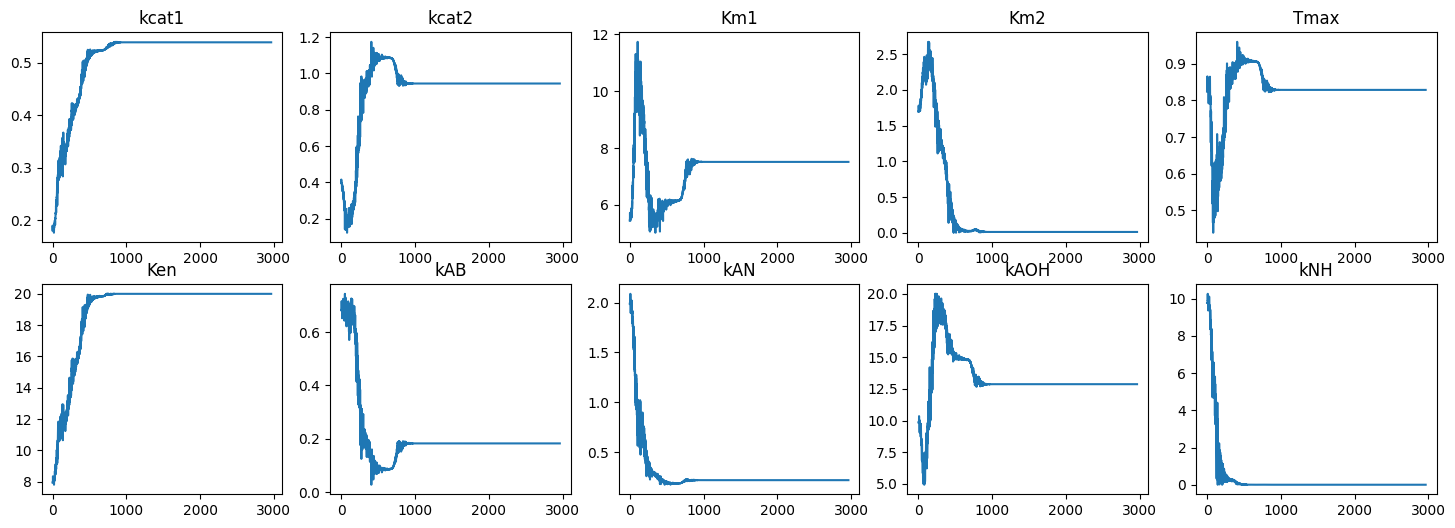

In [73]:
def show_evo(record):
    fig,ax = plt.subplots(2,5,figsize=[18,6])
    ax = ax.flatten()
    record = np.array(record)
    labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']
    N = record.shape[0]
    method = method.replace('-','')
    for idx,g in enumerate(ax):
        g.plot(record[:,idx])
        g.set_title(labels[idx])
        print(labels[idx],P_new[idx])
    #fig.savefig(f"../results/{method}_bat_model_1/{method}_evo.png",dpi=500)

show_evo(record)

In [71]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[10, 10])
    names = ['apa','amox','aoh','ester']
    labels = ['6-APA','Amoxicillin','POHPG', 'POH-PGME']
    mlabels = ['6-APA model','Amoxicillin model','POHPG model', 'POH-PGME model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-k','-k','-k','-k']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-5, val_x[:, idx].max()+5])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()
        

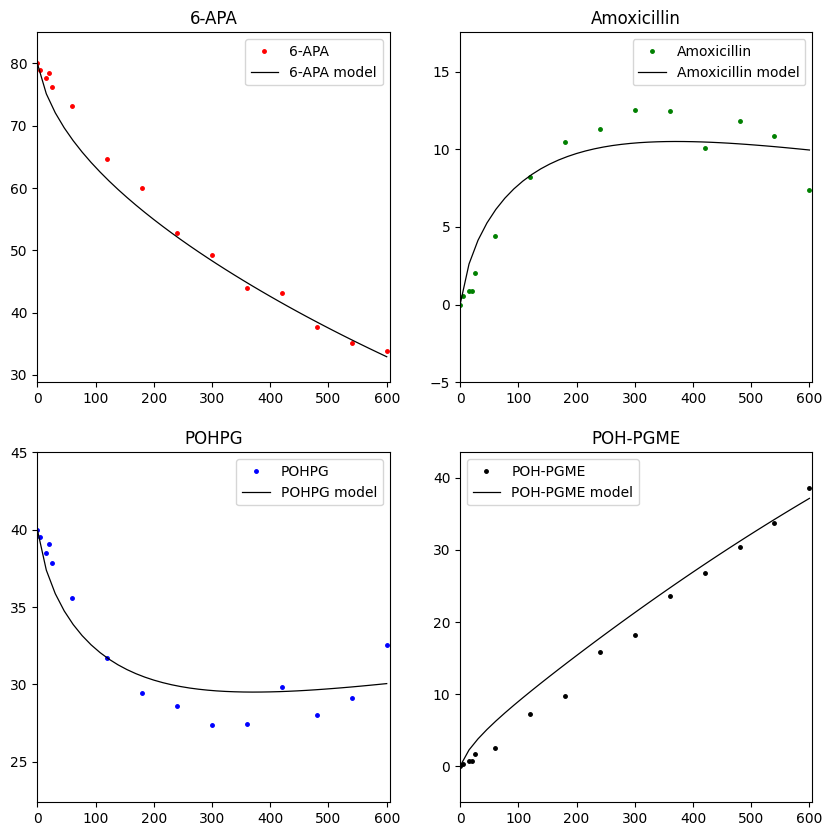

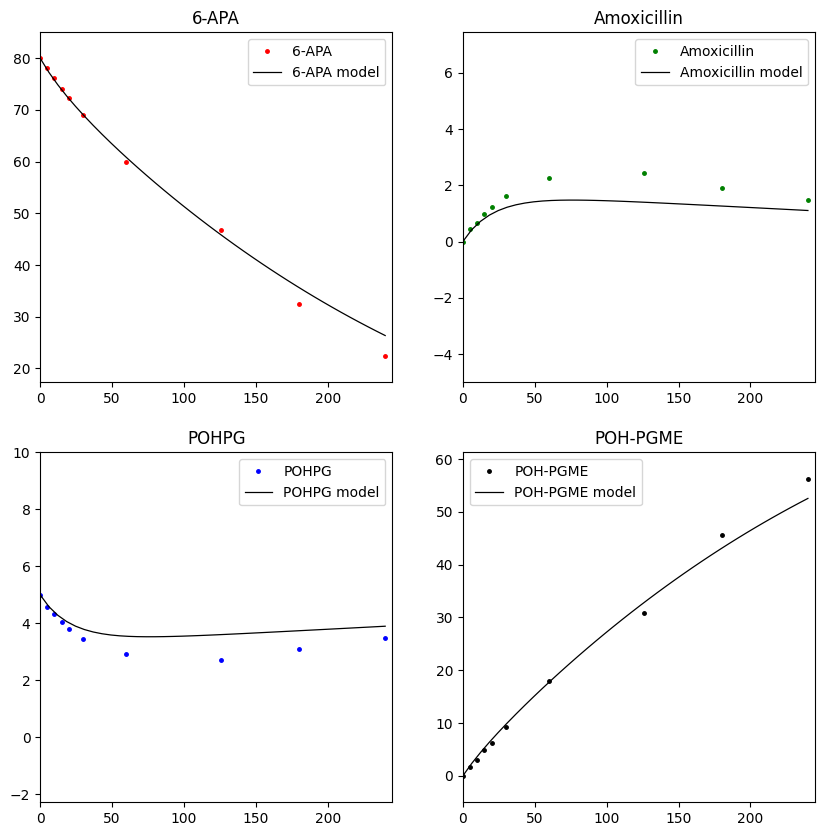

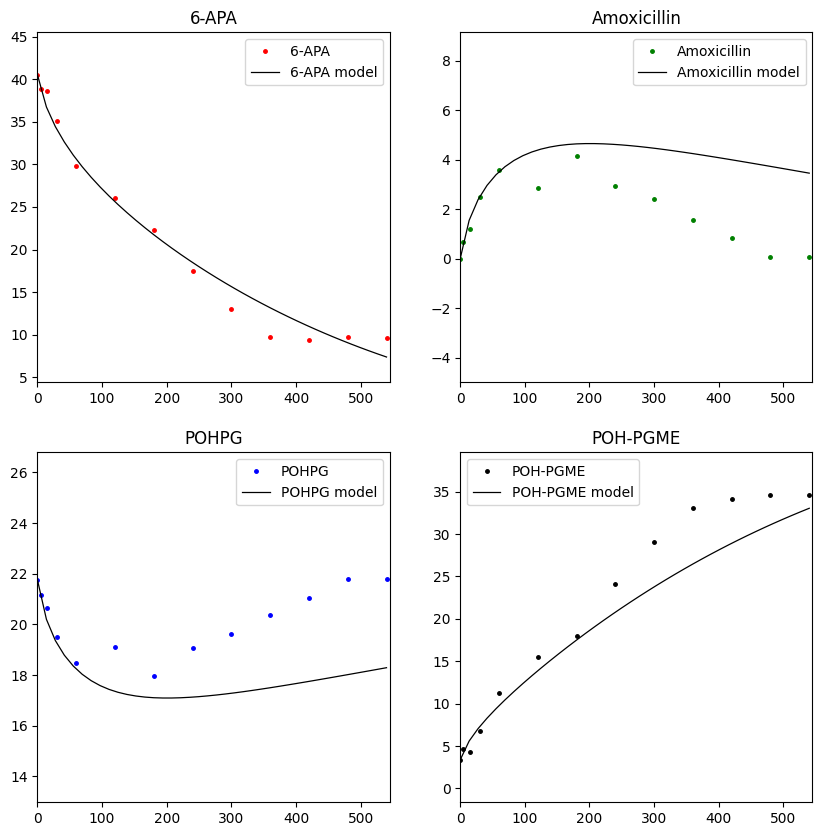

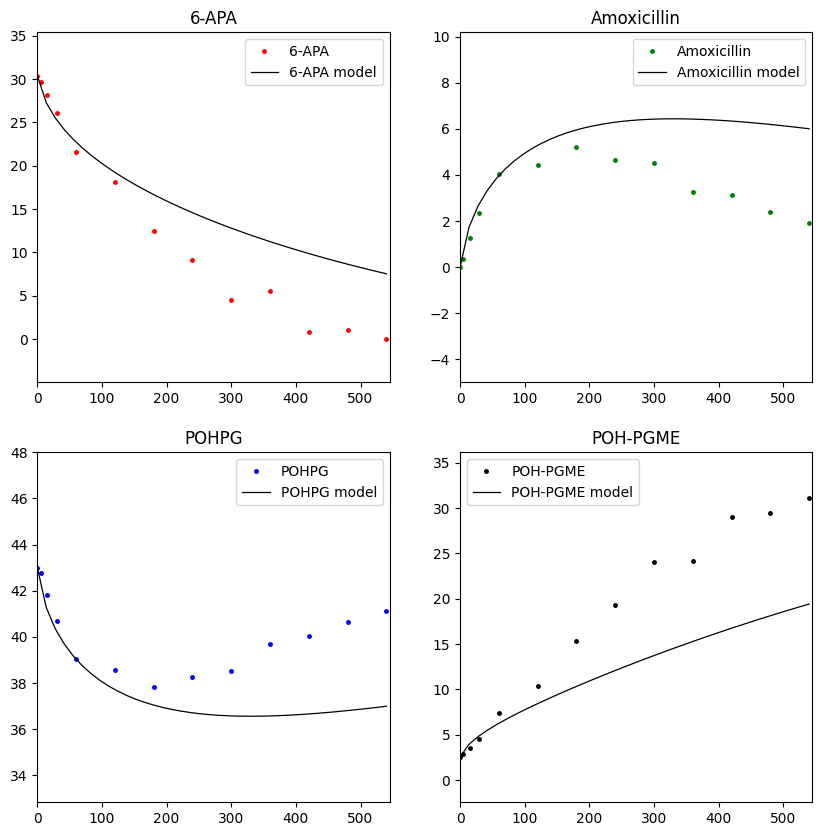

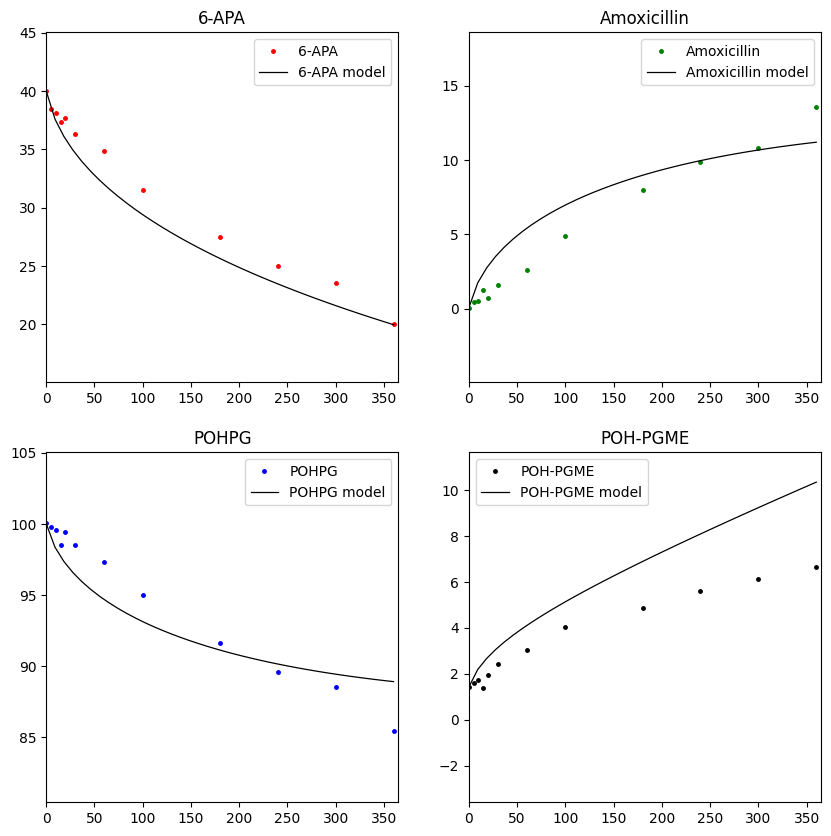

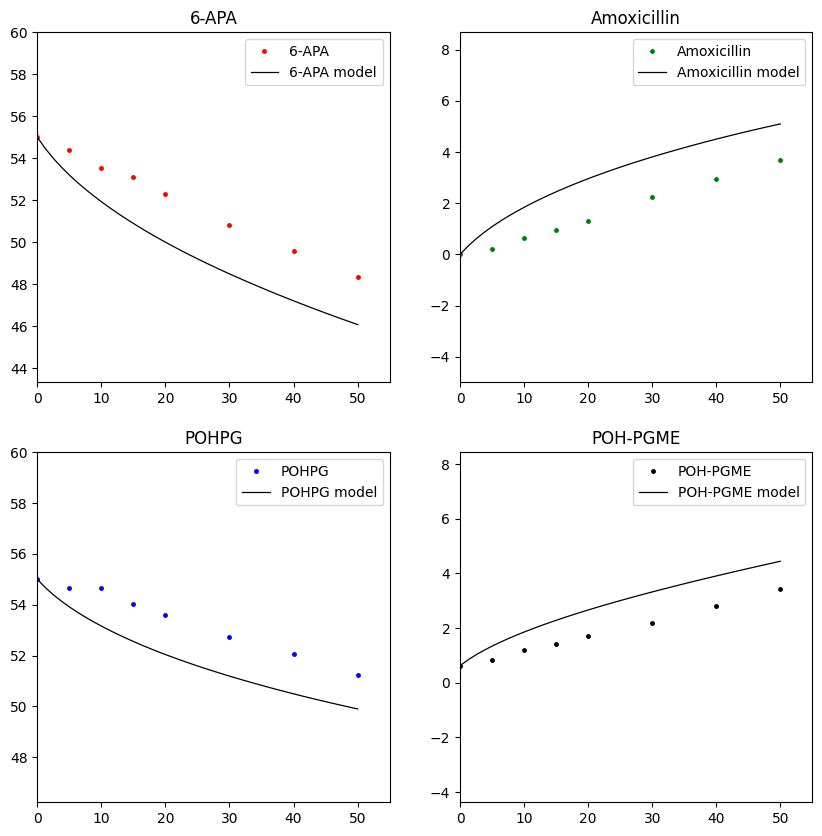

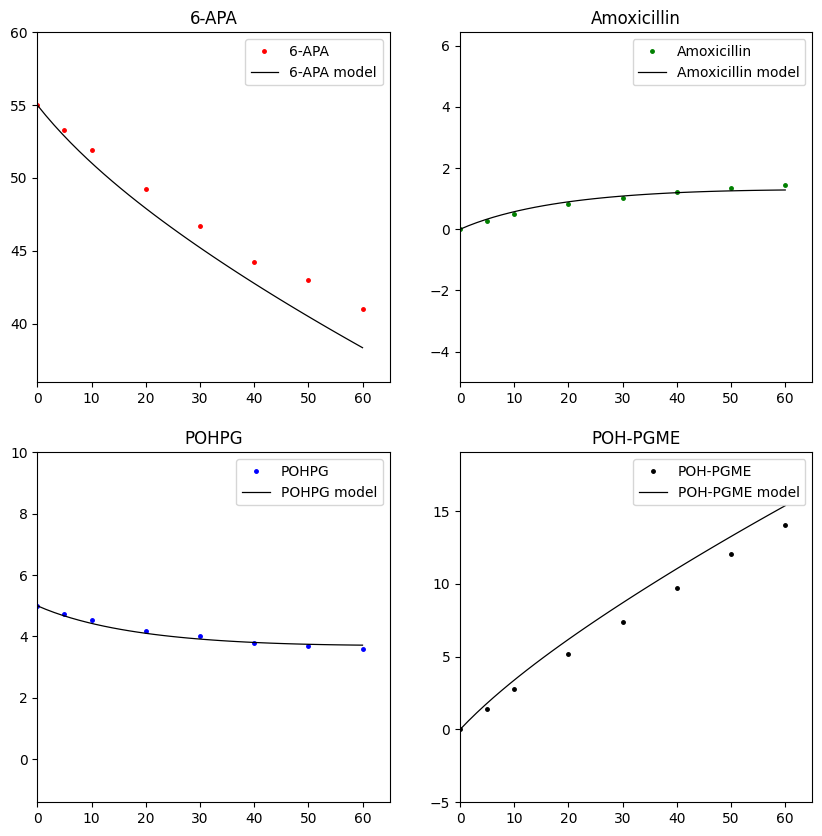

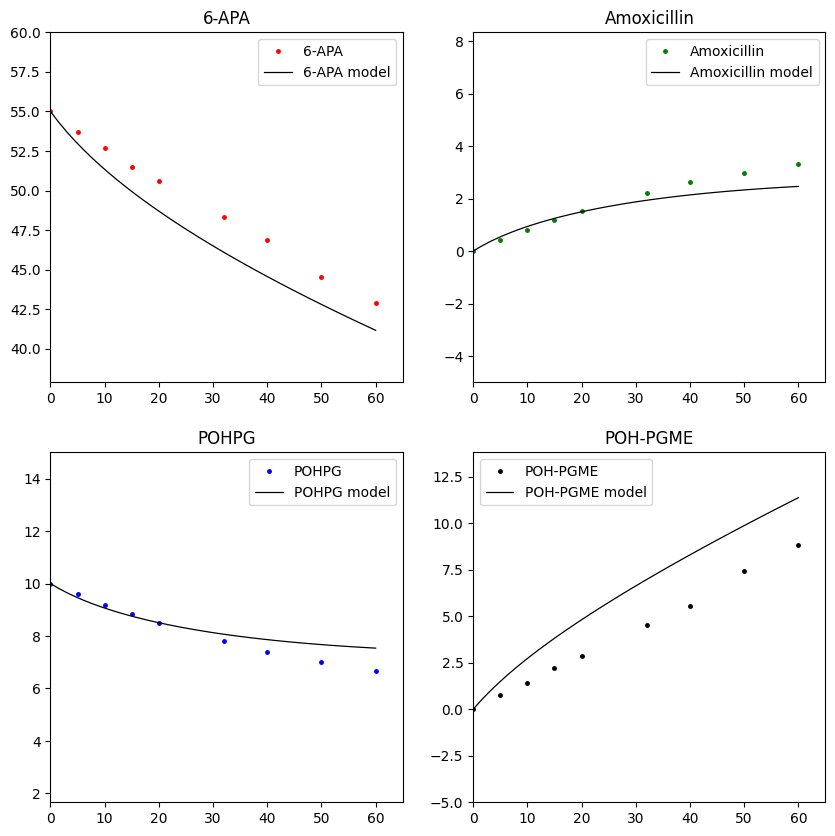

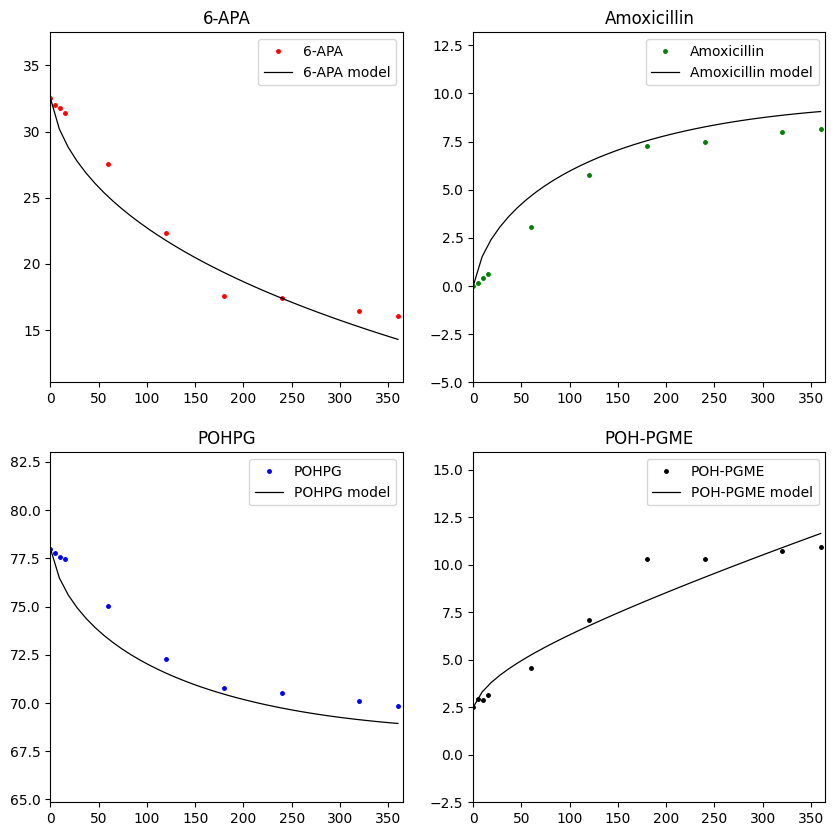

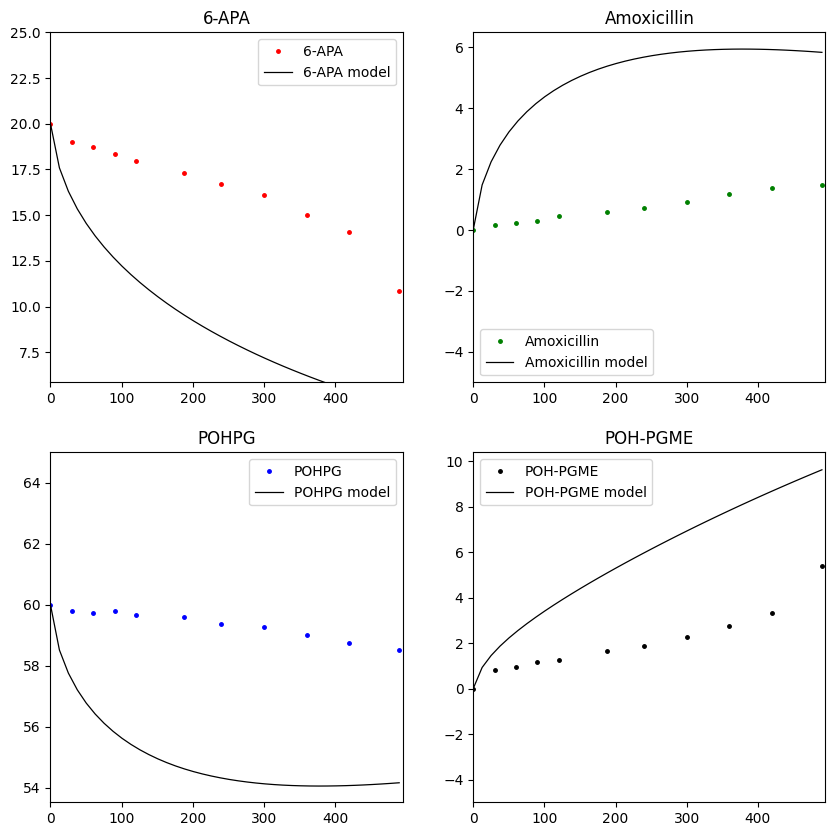

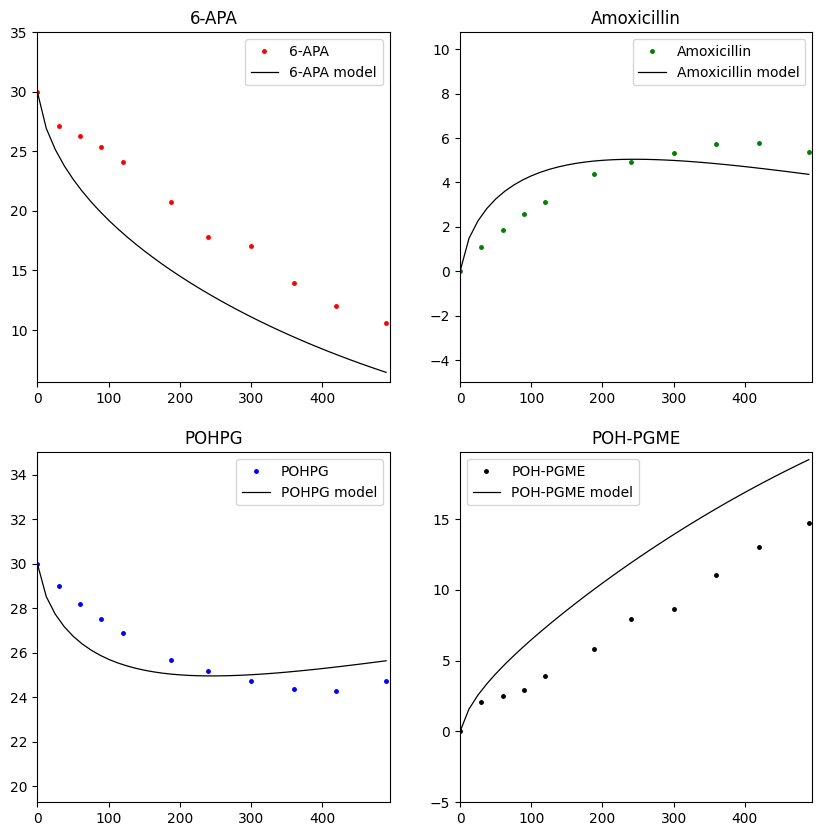

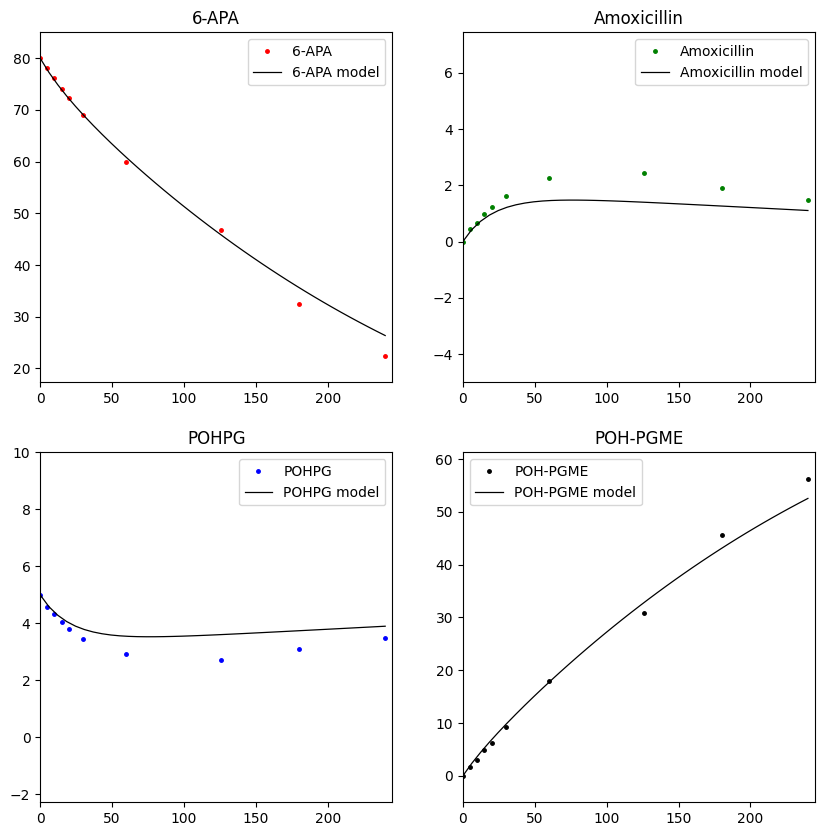

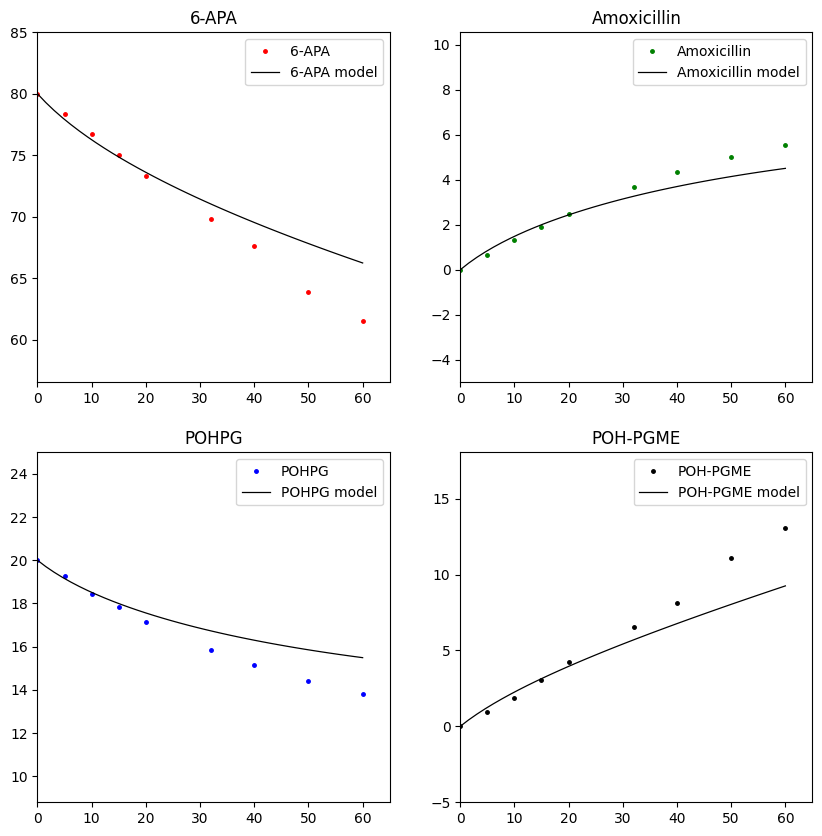

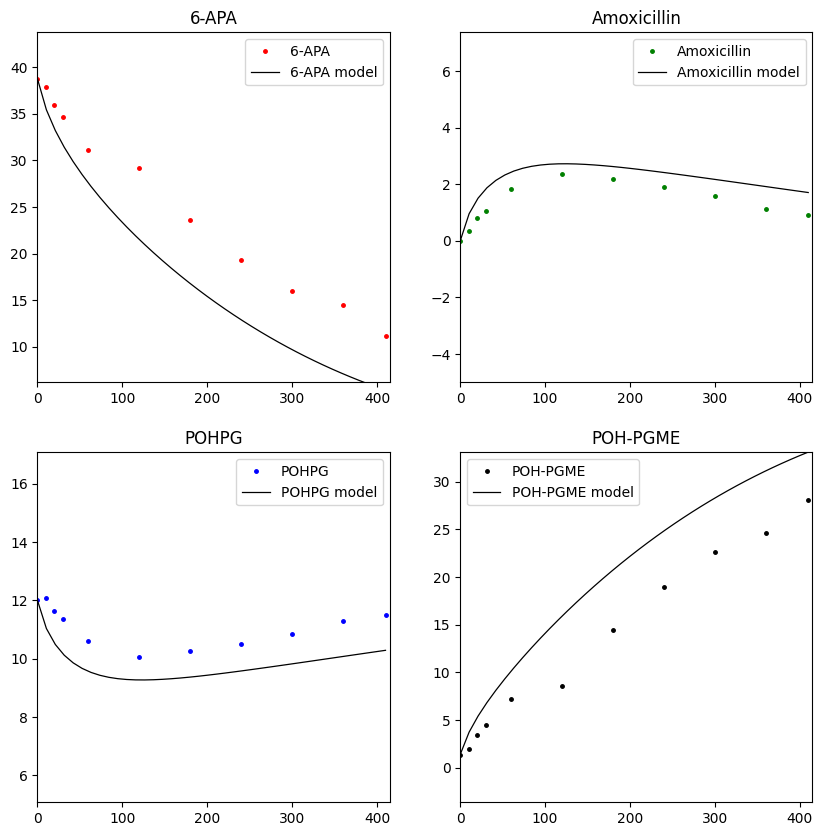

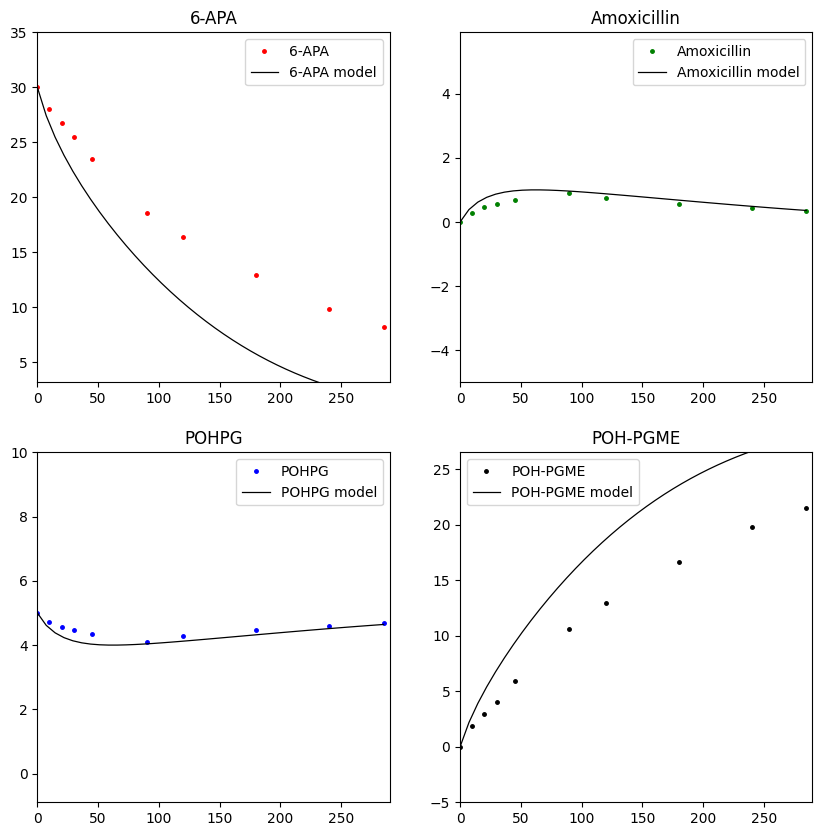

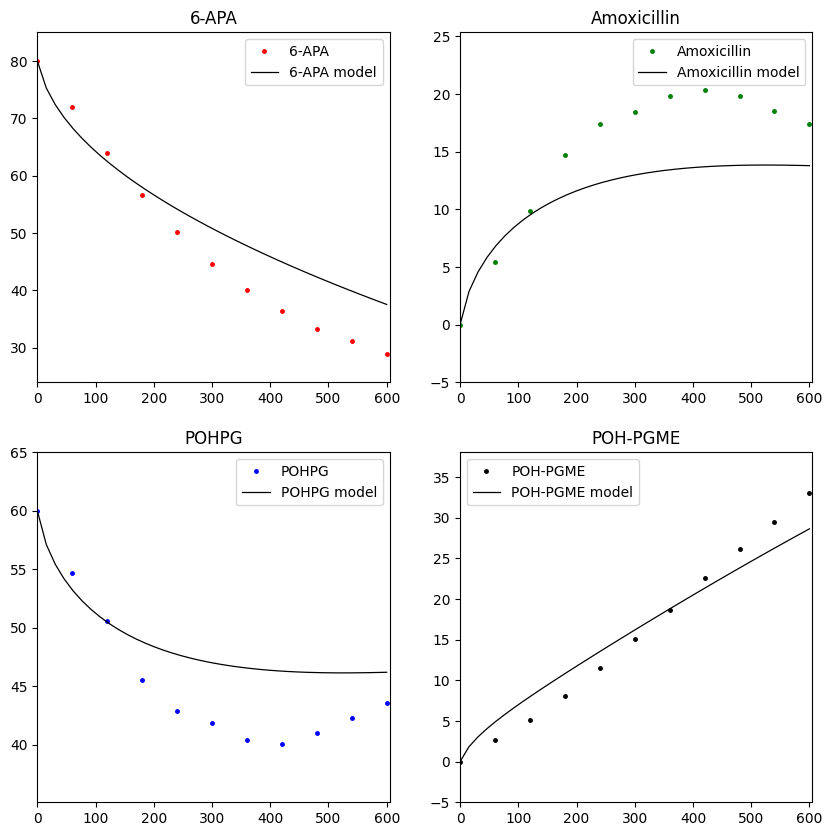

In [72]:
def eval_all(P_new):
    for df in data_frames:
        x_target = df.loc[:,x_names].to_numpy()
        t_target = df['apa_t'].to_numpy()
        ic = x_target[0]
        t_model = np.linspace(t_target[0],t_target[-1],40)
        sol = ode15s_amox(P_new,ic,t_model)
        if sol.status == -1:
            print('failed :(')
        x_model = sol.y.T
        model_eval(x_model,t_model,x_target,t_target)
eval_all(P_new)

In [78]:
print(P_new)

[5.38713819e-01 9.44241559e-01 7.51022020e+00 1.19126584e-02
 8.28424996e-01 1.99988255e+01 1.82226263e-01 2.18026239e-01
 1.28706525e+01 1.00924941e-03]


In [77]:
for lmbd in np.linspace(0.1,1,10):
    print(lmbd)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
